In [109]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [110]:
path = Path('input')

df_train = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')

In [111]:
# Check that data is loaded correctly
print(df_train.shape)
print(df_test.shape) # Should have one less column than df_train (labels)

(891, 12)
(418, 11)


In [112]:
modes = df_train.mode().iloc[0]

In [113]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
    
proc_data(df_train)
proc_data(df_test)

In [114]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"] #Pclass is considered cont because it is ordinal
dep="Survived"

In [115]:
from sklearn.model_selection import train_test_split

trn_df,val_df = train_test_split(df_train, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [116]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

#### Trying out simple RF with 4 leaf nodes

In [117]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [118]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

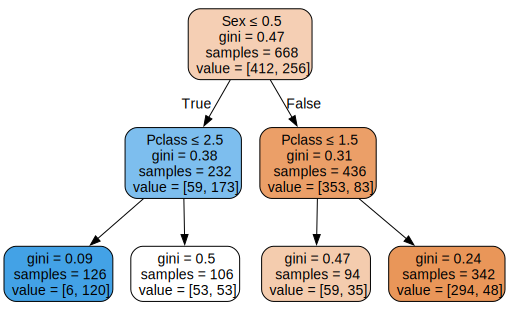

In [119]:
draw_tree(m, trn_xs, size=10)

In [120]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(val_y, m.predict(val_xs))

0.21524663677130046

#### Using number of samples in current branch to determine whether to continue splitting

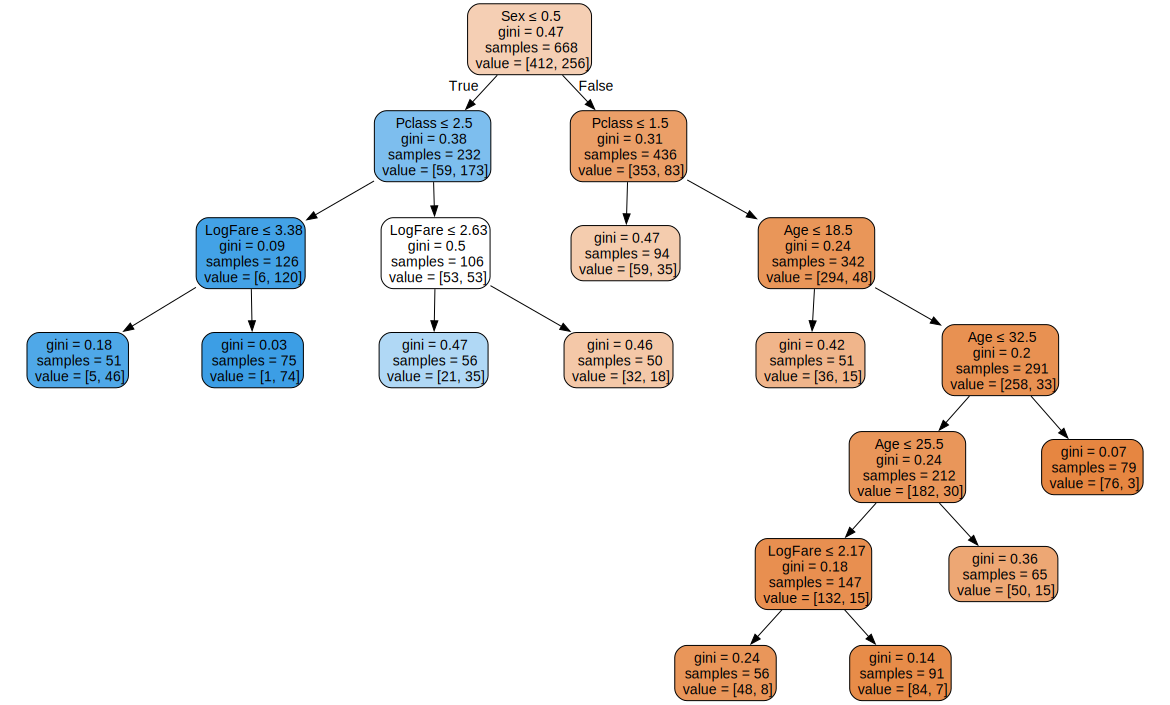

In [121]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=25)

In [122]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2062780269058296

#### Using bagging to improve accuracy

In [123]:
from numpy import random

def get_tree(prop=0.75, min_samples=10):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=min_samples).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [124]:
trees = [get_tree() for t in range(100)]

In [125]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.21085201793721975

#### Comparing against sklearn RandomForestClassifier

In [126]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.17488789237668162